In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

/Users/alexj/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


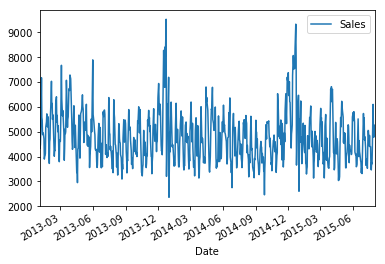

In [2]:
import pandas as pd

# Load the data and set the DateTime index
data = pd.read_csv('../../lessons/lesson-15/assets/dataset/rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_open_data[['Sales']].plot()

**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [3]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140219

In [8]:
store1_data.Sales.autocorr(lag=21) 

0.65146340940726533

Pandas and statsmodels both provide convenience plots for autocorrelations.

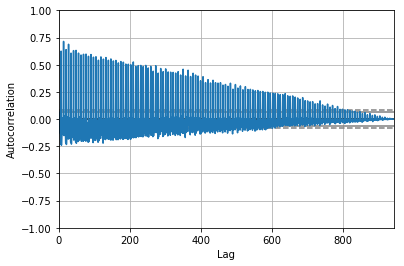

In [6]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_data.Sales)

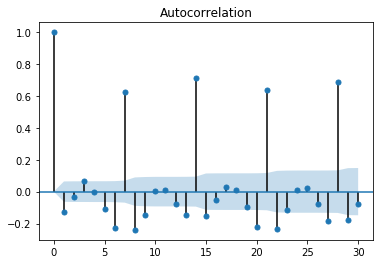

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags=30)
plt.show()

**Check**: What caused the spike at 7?

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [11]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Thu, 15 Jun 2017   AIC                          12540.651
Time:                        21:18:33   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000      4599.969  4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots       

In [12]:
model = ARMA(store1_sales_data, (2, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Thu, 15 Jun 2017   AIC                          12542.063
Time:                        21:21:20   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.3980     85.262     55.856      0.000      4595.287  4929.509
ar.L1.Sales     0.6634      0.036     18.537      0.000         0.593     0.734
ar.L2.Sales     0.0275      0.036      0.767    

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

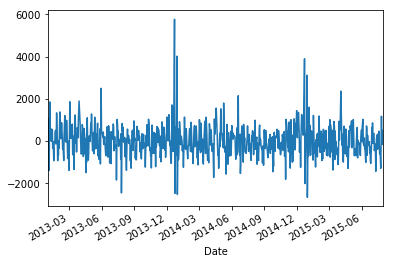

In [13]:
model.resid.plot()

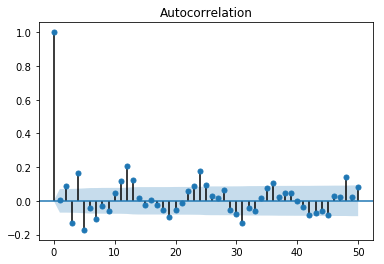

In [14]:
plot_acf(model.resid, lags=50)
plt.show()

Becuase of the errors, it doesn't look like an AR model is good enough -- the data isn't stationary. So let's expand to an `ARMA` model.

In [16]:
model = ARMA(store1_sales_data, (1, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 2)   Log Likelihood               -6262.771
Method:                       css-mle   S.D. of innovations            734.770
Date:                Thu, 15 Jun 2017   AIC                          12535.543
Time:                        21:29:22   BIC                          12558.846
Sample:                    07-31-2015   HQIC                         12544.505
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.7343     76.974     61.875      0.000      4611.868  4913.600
ar.L1.Sales     0.5766      0.071      8.135      0.000         0.438     0.716
ma.L1.Sales     0.1091      0.084      1.292    

In [18]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (1, 0, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 2)   Log Likelihood               -6262.771
Method:                       css-mle   S.D. of innovations            734.770
Date:                Thu, 15 Jun 2017   AIC                          12535.543
Time:                        21:37:48   BIC                          12558.846
Sample:                    07-31-2015   HQIC                         12544.505
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.7343     76.974     61.875      0.000      4611.868  4913.600
ar.L1.Sales     0.5766      0.071      8.135      0.000         0.438     0.716
ma.L1.Sales     0.1091      0.084      1.292    

In [24]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Thu, 15 Jun 2017   AIC                          12506.358
Time:                        21:44:46   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.313      0.189        -0.250     1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000        -0.279    -0.085
ar.L2.D.Sales     0.6469      0.035     

In [20]:
model = ARIMA(store1_sales_data, (2, 1, 0)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6313.493
Method:                       css-mle   S.D. of innovations            792.554
Date:                Thu, 15 Jun 2017   AIC                          12634.985
Time:                        21:40:16   BIC                          12653.622
Sample:                    07-30-2015   HQIC                         12642.153
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.1628     23.604      0.007      0.994       -46.100    46.426
ar.L1.D.Sales    -0.1847      0.036     -5.155      0.000        -0.255    -0.114
ar.L2.D.Sales    -0.0178      0.036     

In [21]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

-0.18144101447610664

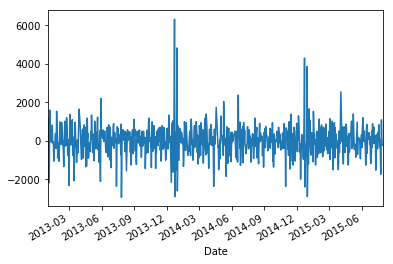

In [22]:
store1_sales_data.Sales.diff(1).plot()
plt.show()

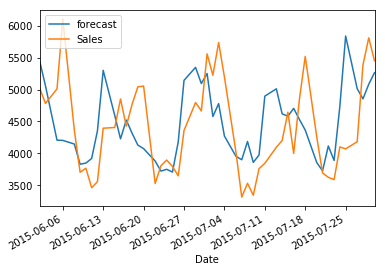

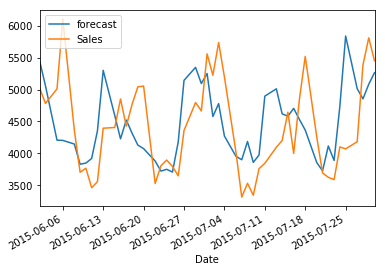

In [25]:
model.plot_predict(1, 50)

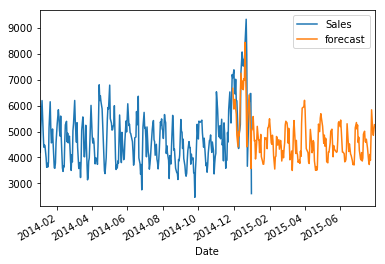

In [26]:
fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

In [27]:
model = ARIMA(store1_sales_data, (2, 2, 2)).fit()
model.summary()
model.bse
plot_acf(model.resid, lags=50)
plt.show()

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.